In [2]:
import sys
import numpy as np
import pandas as pd
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import copy
from IPython.display import display
from aif360.datasets import MEPSDataset19
from aif360.datasets import StandardDataset


from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from sklearn.ensemble import RandomForestClassifier
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools


# Ensure reproducibility
np.random.seed(1)

# Append a path if needed
sys.path.append("../")


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [3]:
def further_preprocessing_aif360_no_categorical(meps_dataset):
    # Convert MEPSDataset19 to a DataFrame
    df, metadata = meps_dataset.convert_to_dataframe()

    # Step 1: Clean invalid values for PCS42 and MCS42
    for col in ['PCS42', 'MCS42']:
        if col in df.columns:
            # Replace negative values with NaN
            df[col] = df[col].apply(lambda x: pd.NA if x < 0 else x)
            # Fill NaN values with the column median
            df[col] = df[col].fillna(df[col].median(skipna=True))

    # Step 2: Discretize PCS42 and MCS42 into bins
    num_bins = 10  # Number of bins for discretization
    df['PCS42_bin'] = pd.qcut(df['PCS42'], q=num_bins, labels=False, duplicates='drop')
    df['MCS42_bin'] = pd.qcut(df['MCS42'], q=num_bins, labels=False, duplicates='drop')

    # Drop the original continuous columns
    df.drop(columns=['PCS42', 'MCS42'], inplace=True)

    #Rename back 
    df.rename(columns={'PCS42_bin': 'PCS42'}, inplace=True)
    df.rename(columns={'MCS42_bin': 'MCS42'}, inplace=True)

    # Step 3: Rename SEX column and clean up
    df.rename(columns={'SEX=1': 'SEX'}, inplace=True)

    # Step 4: Retain only numerical features, including discretized bins
    selected_columns = ['RACE', 'SEX', 'PCS42', 'MCS42', 'UTILIZATION']
    df = df[selected_columns]

    # Step 5: Create the processed AIF360 dataset
    processed_dataset = StandardDataset(
        df,
        label_name='UTILIZATION',
        favorable_classes=[1.0],
        protected_attribute_names=['RACE', 'SEX'],
        privileged_classes=[[1.0], [1.0]],  # Privileged groups: White and Male
    )


    # Add protected_attribute_maps
    protected_attribute_maps = [
        {1.0: 'White', 0.0: 'Non-white'},  # For RACE
        {1.0: 'Male', 0.0: 'Female'}       # For SEX
    ]
    processed_dataset.metadata['protected_attribute_maps'] = protected_attribute_maps

    # Add label_maps 
    label_maps = [{1.0: 'Utilized', 0.0: 'Not Utilized'}]  # For UTILIZATION label
    processed_dataset.metadata['label_maps'] = label_maps

    

    return processed_dataset


# Instantiate MEPSDataset19
meps = MEPSDataset19()

# Apply further preprocessing
processed_meps = further_preprocessing_aif360_no_categorical(meps)

# Inspect the AIF360 dataset
print(processed_meps.feature_names)


['RACE', 'SEX', 'PCS42', 'MCS42']


In [4]:
privileged_groups = [{'RACE': 1}]
unprivileged_groups = [{'RACE': 0}]
preprocessed_dataset = processed_meps
train, val_test = preprocessed_dataset.split([0.7], shuffle=True)
val, test = val_test.split([0.5], shuffle=True)

In [5]:
# Evaluate fairness metrics before applying bias mitigation
metric_train = BinaryLabelDatasetMetric(train, unprivileged_groups, privileged_groups)
print("Train Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_train.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train.disparate_impact():.4f}")

metric_test = BinaryLabelDatasetMetric(test, unprivileged_groups, privileged_groups)
print("\nTest Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_test.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test.disparate_impact():.4f}")

Train Dataset (Before Transformation):
  Statistical Parity Difference: -0.1294
  Disparate Impact: 0.4888

Test Dataset (Before Transformation):
  Statistical Parity Difference: -0.1462
  Disparate Impact: 0.4701


In [6]:

def get_distortion_medical(vold, vnew):
    
    # Helper function to adjust UTILIZATION labels to numeric values
    def adjustUtil(a):
        if a == "Utilized":
            return 1
        elif a == "Not Utilized":
            return 0
        else:
            return int(a)

    # Helper functions to clean PCS42_bin and MCS42_bin
    def adjustBin(b):
        return int(b) if b is not None else 0  # Default to 0 for safety

    # Value that represents a large penalty for invalid transformations
    bad_val = 3.0

    # Adjust PCS42_bin and MCS42_bin
    pcs_old = adjustBin(vold['PCS42'])
    pcs_new = adjustBin(vnew['PCS42'])

    mcs_old = adjustBin(vold['MCS42'])
    mcs_new = adjustBin(vnew['MCS42'])

    # PCS42_bin and MCS42_bin cannot change by more than 1 bin
    if abs(pcs_new - pcs_old) > 1 or abs(mcs_new - mcs_old) > 1:
        return bad_val  # Large jumps are heavily penalized

    # Adjust UTILIZATION
    util_old = adjustUtil(vold['UTILIZATION'])
    util_new = adjustUtil(vnew['UTILIZATION'])

    # Initialize distortion penalty
    distortion = 0

    # Penalty for changes in PCS42_bin and MCS42_bin
    if pcs_new != pcs_old:
        distortion += 1.0
    if mcs_new != mcs_old:
        distortion += 1.0

    # Penalty for changes in UTILIZATION
    if util_old > util_new:  # Decrease in UTILIZATION (undesirable)
        distortion += 2.0
    elif util_old < util_new:  # Increase in UTILIZATION
        distortion += 1.0

    return distortion


In [27]:
optim_options = {
    "distortion_fun": get_distortion_medical,
    "epsilon": 0.01, #0.05
    "clist": [0.99],
    "dlist": [.1]
}  

In [28]:
# Initialize OptimPreproc
optim_preproc = OptimPreproc(OptTools, optim_options,
                  unprivileged_groups = unprivileged_groups,
                  privileged_groups = privileged_groups)

optim_preproc = optim_preproc.fit(train)

# Fit and transform training data
train_transf = optim_preproc.transform(train)
train_transf = train.align_datasets(train_transf)



c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\algorithms\preprocessing\optim_preproc.py:68: UserWarning: Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.
  warn("Privileged and unprivileged groups specified will not be "
c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\expressions\expression.py:667: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 17 times so far.

  warnings.warn(ms

Optimized Preprocessing: Objective converged to 0.031157


c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\algorithms\preprocessing\optim_preproc.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfP_withY = self.OpT.dfP.applymap(lambda x: 0 if x < 1e-8 else x)


In [29]:
val_transf = optim_preproc.transform(val)
val_transf = val.align_datasets(val_transf)

test_transf = optim_preproc.transform(test)
test_transf = test.align_datasets(test_transf)

c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\algorithms\preprocessing\optim_preproc.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfP_withY = self.OpT.dfP.applymap(lambda x: 0 if x < 1e-8 else x)
c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\algorithms\preprocessing\optim_preproc.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfP_withY = self.OpT.dfP.applymap(lambda x: 0 if x < 1e-8 else x)


In [30]:
# Evaluate fairness metrics after applying LFR
metric_train_after = BinaryLabelDatasetMetric(train_transf, unprivileged_groups, privileged_groups)
print("\nTrain Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_train_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train_after.disparate_impact():.4f}")

metric_test_after = BinaryLabelDatasetMetric(test_transf, unprivileged_groups, privileged_groups)
print("\nTest Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_test_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test_after.disparate_impact():.4f}")



Train Dataset (After Transformation):
  Statistical Parity Difference: -0.0032
  Disparate Impact: 0.9842

Test Dataset (After Transformation):
  Statistical Parity Difference: -0.0338
  Disparate Impact: 0.8559


In [31]:
# Standardize the features
scaler = StandardScaler()
train.features = scaler.fit_transform(train.features)
val.features = scaler.transform(val.features)
test.features = scaler.transform(test.features)


Train a classifier with original data.

In [32]:
classifier = RandomForestClassifier(max_depth=None, max_leaf_nodes=6, max_features=3)


In [33]:
# Train a classifier on original training data
classifier.fit(train.features, train.labels.ravel())

# Predict on validation set
val_scores = classifier.predict_proba(val.features)[:, 1] #only for the favorable class?

# Select best threshold for validation set
thresholds = np.arange(0.01, 1, 0.01)
val_balanced_accs = []

for threshold in thresholds:
    val_LR_predictions = (val_scores >= threshold).astype(int)

    val_with_LR_scores = copy.deepcopy(val)
    val_with_LR_scores.labels = val_LR_predictions.reshape(-1, 1)  # Update labels with predictions

    val_metric = ClassificationMetric(val, val_with_LR_scores,
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
    balanced_acc = (val_metric.true_positive_rate() + val_metric.true_negative_rate()) / 2
    disparate_impact = val_metric.disparate_impact()
    avg_odds_diff = val_metric.average_odds_difference()

    val_balanced_accs.append(balanced_acc)

best_index = np.argmax(val_balanced_accs)
best_threshold = thresholds[best_index]
best_balanced_acc = val_balanced_accs[best_index]

print(f"Best Threshold (validation): {best_threshold}")
print(f"Best Balanced Accuracy (validation): {best_balanced_acc}")

Best Threshold (validation): 0.16
Best Balanced Accuracy (validation): 0.7422172271620884


c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


In [34]:


# Apply the best threshold to the test set
test_scores = classifier.predict_proba(test.features)[:, 1]
test_LR_predictions= (test_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_with_LR_scores = copy.deepcopy(test)
test_with_LR_scores.labels = test_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_metric = ClassificationMetric(test, test_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_metric.true_positive_rate()
true_negative_rate = test_metric.true_negative_rate()
balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy}")

# Statistical Parity Difference
statistical_parity_difference = test_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference}")

# Disparate Impact
disparate_impact = test_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact}")

# Average Odds Difference
average_odds_difference = test_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference}")

# Equal Opportunity Difference
equal_opportunity_difference = test_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference}")

# Theil Index
theil_index = test_metric.theil_index()
print(f"Theil Index (test): {theil_index}")

Balanced Accuracy (test): 0.687124043789832
Statistical Parity Difference (test): -0.32603157457018717
Disparate Impact (test): 0.3560470890330133
Average Odds Difference (test): -0.25819972349255327
Equal Opportunity Difference (test): -0.22026951776367076
Theil Index (test): 0.12304755556677816


In [35]:
# Plot Test Metrics Over Thresholds
test_balanced_accs = []
test_disp_impacts = []
test_avg_odds_diffs = []

for threshold in thresholds:
    test_predictions = (test_scores >= threshold).astype(int)
    test_with_scores = copy.deepcopy(test)
    test_with_scores.labels = test_predictions.reshape(-1, 1)

    test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
    test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
    test_disp_impacts.append(test_metric.disparate_impact())
    test_avg_odds_diffs.append(test_metric.average_odds_difference())

c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


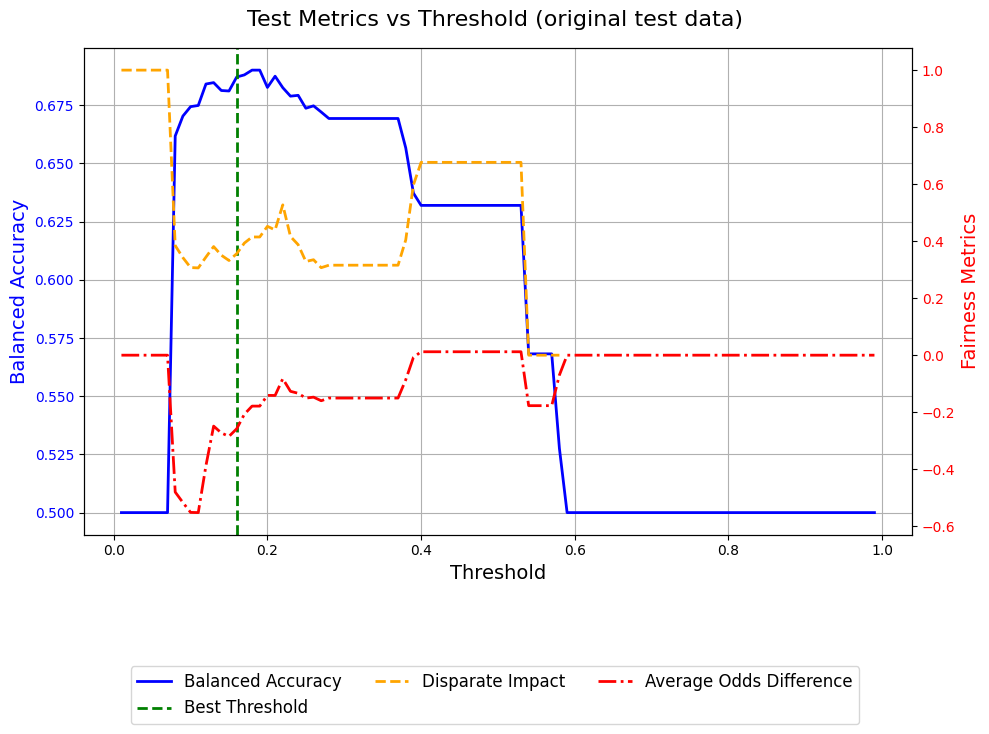

In [36]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (original test data)", fontsize=16)
fig.tight_layout()
plt.show()

now they are transformed and we train logistic regression on trained data. TRAIN classifier with transformed data.

In [37]:
# Train a classifier on transformed training data
classifier.fit(train_transf.features, train_transf.labels.ravel())


RandomForestClassifier(max_features=3, max_leaf_nodes=6)

In [38]:
# Apply the best threshold to the transf test set
test_transf_scores = classifier.predict_proba(test_transf.features)[:, 1]
test_transf_LR_predictions= (test_transf_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_transf_with_LR_scores = copy.deepcopy(test)
test_transf_with_LR_scores.labels = test_transf_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_transf_metric = ClassificationMetric(test, test_transf_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_transf_metric.true_positive_rate()
true_negative_rate = test_transf_metric.true_negative_rate()
balanced_accuracy_transf = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy_transf}")

# i shall change all these metrics to _transf
# Statistical Parity Difference
statistical_parity_difference_transf = test_transf_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference_transf}")

# Disparate Impact
disparate_impact_transf = test_transf_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact_transf}")

# Average Odds Difference
average_odds_difference_transf = test_transf_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference_transf}")

# Equal Opportunity Difference
equal_opportunity_difference_transf = test_transf_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference_transf}")

# Theil Index
theil_index_transf = test_transf_metric.theil_index()
print(f"Theil Index (test): {theil_index_transf}")

Balanced Accuracy (test): 0.6680179733663434
Statistical Parity Difference (test): -0.12814483069574628
Disparate Impact (test): 0.7364067472217033
Average Odds Difference (test): -0.06811775166659514
Equal Opportunity Difference (test): -0.04497160040093551
Theil Index (test): 0.11681587684808241


In [39]:
# Plot Test Metrics Over Thresholds
test_transf_balanced_accs = []
test_transf_disp_impacts = []
test_transf_avg_odds_diffs = []

for threshold in thresholds:
    test_transf_predictions = (test_transf_scores >= threshold).astype(int)
    test_transf_with_scores = copy.deepcopy(test)
    test_transf_with_scores.labels = test_transf_predictions.reshape(-1, 1)

    test_transf_metric = ClassificationMetric(test, test_transf_with_scores, unprivileged_groups, privileged_groups)
    test_transf_balanced_accs.append((test_transf_metric.true_positive_rate() + test_transf_metric.true_negative_rate()) / 2)
    test_transf_disp_impacts.append(test_transf_metric.disparate_impact())
    test_transf_avg_odds_diffs.append(test_transf_metric.average_odds_difference())

c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


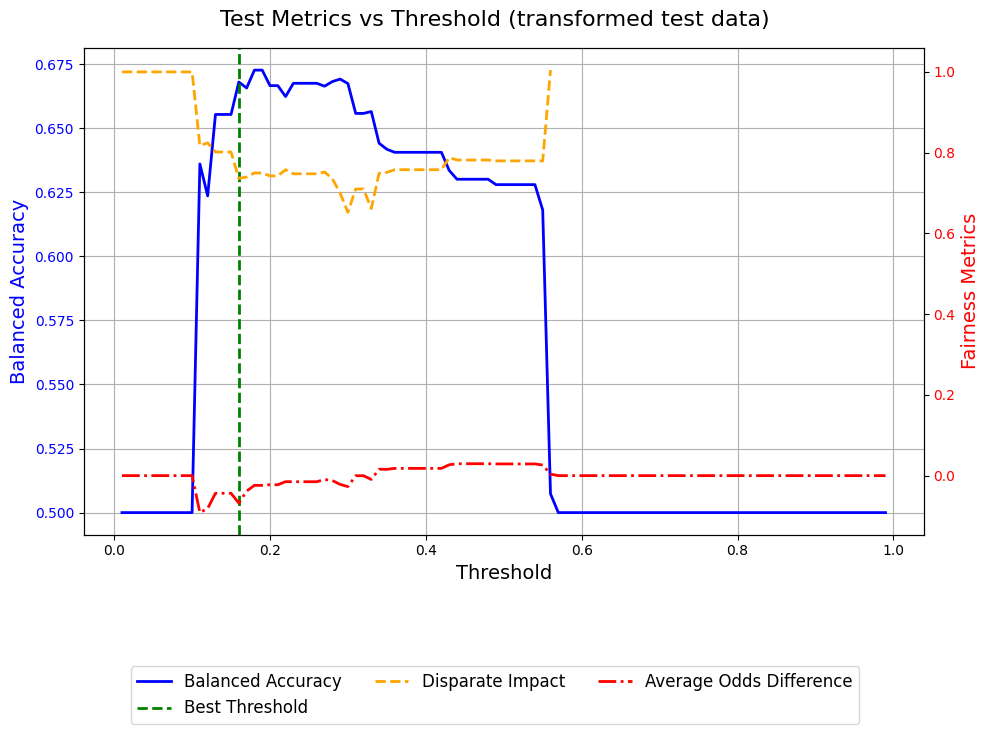

In [40]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_transf_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_transf_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_transf_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (transformed test data)", fontsize=16)
fig.tight_layout()
plt.show()

In [41]:
# Organizing the metrics with actual calculated values
results_data = {
    "Dataset": [
        "Train", "Train", "Test", "Test", 
        "Train", "Train", "Test", "Test", 
        "Validation", "Validation", 
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)"
    ],
    "Stage": [
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Best Threshold (Validation)", "Best Threshold (Validation)",
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold"
    ],
    "Metric": [
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Disparate Impact", "Disparate Impact",
        "Disparate Impact", "Disparate Impact",
        "Threshold", "Balanced Accuracy",
        "Balanced Accuracy", "Balanced Accuracy", 
        "Statistical Parity Difference", "Statistical Parity Difference", 
        "Disparate Impact", "Disparate Impact",
        "Average Odds Difference", "Average Odds Difference",
        "Equal Opportunity Difference", "Equal Opportunity Difference", 
        "Theil Index", "Theil Index"
    ],
    "Value": [
        metric_train.mean_difference(),
        metric_train_after.mean_difference(),
        metric_test.mean_difference(),
        metric_test_after.mean_difference(),
        metric_train.disparate_impact(),
        metric_train_after.disparate_impact(),
        metric_test.disparate_impact(),
        metric_test_after.disparate_impact(),
        best_threshold,
        best_balanced_acc,
        balanced_accuracy, balanced_accuracy_transf,
        statistical_parity_difference, statistical_parity_difference_transf,
        disparate_impact, disparate_impact_transf,
        average_odds_difference, average_odds_difference_transf,
        equal_opportunity_difference, equal_opportunity_difference_transf,
        theil_index, theil_index_transf
    ]
}

# Create the DataFrame
results_table = pd.DataFrame(results_data)

# Display the table
#display(results_table)


**Fairness Metrics Before and After Transformation**
- This table represents the fairness metrics (Statistical Parity Difference and Disparate Impact) for both the train and test datasets, before and after applying the transformation.

**Validation Metrics for Threshold Selection**
- This table contains metrics related to the validation phase, including the best threshold and corresponding balanced accuracy.

**Test Metrics After Applying Threshold**
- This table summarizes fairness and performance metrics calculated on the test set of the original and transformed dataset after applying the selected threshold.


In [42]:

# Separate the data into three groups
fairness_metrics = results_table.iloc[0:8].reset_index(drop=True)
validation_metrics = results_table.iloc[8:10].reset_index(drop=True)
test_metrics = results_table.iloc[10:22].reset_index(drop=True)

# Name the tables
fairness_metrics.name = "Fairness Metrics Before and After Transformation"
validation_metrics.name = "Validation Metrics for Threshold Selection"
test_metrics.name = "Test Metrics After Applying Threshold On Original and Transformed"

# Display the tables with their names
for table in [fairness_metrics, validation_metrics, test_metrics]:
    display(table.name)
    display(table)



'Fairness Metrics Before and After Transformation'

,Dataset,Stage,Metric,Value
0,Train,Before Transformation,Statistical Parity Difference,-0.129388
1,Train,After Transformation,Statistical Parity Difference,-0.003182
2,Test,Before Transformation,Statistical Parity Difference,-0.146154
3,Test,After Transformation,Statistical Parity Difference,-0.033751
4,Train,Before Transformation,Disparate Impact,0.488762
5,Train,After Transformation,Disparate Impact,0.984222
6,Test,Before Transformation,Disparate Impact,0.470109
7,Test,After Transformation,Disparate Impact,0.855924


'Validation Metrics for Threshold Selection'

,Dataset,Stage,Metric,Value
0,Validation,Best Threshold (Validation),Threshold,0.160000
1,Validation,Best Threshold (Validation),Balanced Accuracy,0.742217


'Test Metrics After Applying Threshold On Original and Transformed'

,Dataset,Stage,Metric,Value
0,Test (Original),After Threshold,Balanced Accuracy,0.687124
1,Test (Transformed),After Threshold,Balanced Accuracy,0.668018
2,Test (Original),After Threshold,Statistical Parity Difference,-0.326032
3,Test (Transformed),After Threshold,Statistical Parity Difference,-0.128145
4,Test (Original),After Threshold,Disparate Impact,0.356047
5,Test (Transformed),After Threshold,Disparate Impact,0.736407
6,Test (Original),After Threshold,Average Odds Difference,-0.258200
7,Test (Transformed),After Threshold,Average Odds Difference,-0.068118
8,Test (Original),After Threshold,Equal Opportunity Difference,-0.220270
9,Test (Transformed),After Threshold,Equal Opportunity Difference,-0.044972
